# Anomaly Detection

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('/Users/josuealemansanchez/Desktop/eco-tools')
from ecotools.pi_client import pi_client
pc = pi_client(root = 'readonly')
from data_helper import *
import warnings
warnings.filterwarnings('ignore')

## Get Data

In [2]:
#search for point if needed
point = pc.search_by_point('*gbsf*elec*demand*kbtu*')
point

['GBSF_Electricity_Demand_kBtu']

### Set Data Parameters

In [3]:
start = '2016-01-01'
end = '*'
interval = '1h'
calculation = 'summary'

### Ensure only one point is passed

Grabbing WebIDs ...
WebID collection complete!
11:09:41: Sending API request... Chunk 1 of 1
11:09:43: Response recieved for 1 tags! (1.51)


Column                      |Percent NaN | Rows NaN/Total Rows
--------------------------------------------------------------
GBSF_Electricity_Demand_kBtu|  0.07 %    | 23/31663


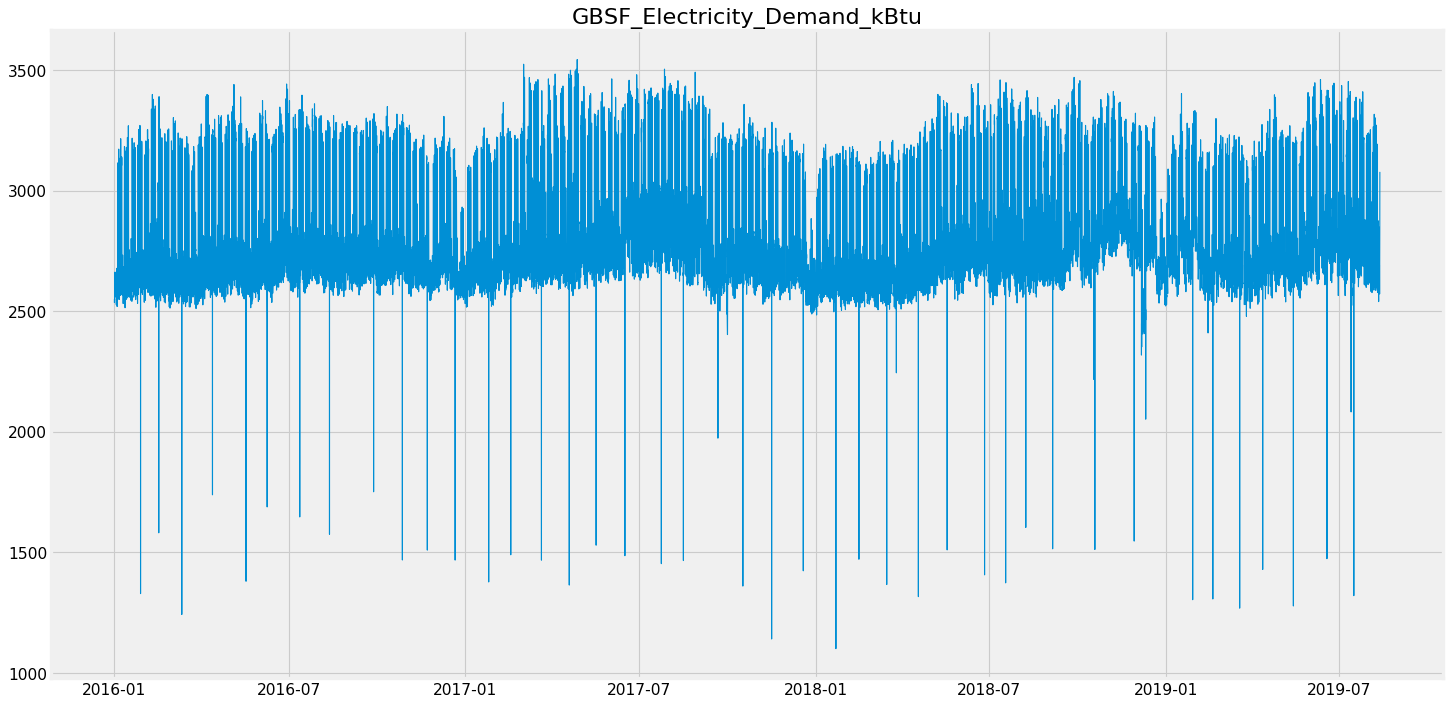

In [4]:
df = pc.get_stream_by_point(point, start = start, end = end, interval = interval, calculation = calculation)
print_report(df)

## Generate Model

In [5]:
kwargs = {
    #the point to be evaluated
    'point': point[0],
    
    #can be either 'LSTM' or 'Random Forest'
    'model_type': 'LSTM',
################################### Data Pre-processing ################################    
    #Determining the amount of data that will be used to train the model 0 < training_percent < 1.0
    'training_percent': 0.7,
    
    #determine if use wants the data to be cleaned 
    'clean_data': True,
    #TODO: Add upper and lower cutoff values
    #clean_type can be either 'value' (any points below the value passed will be cut out) or 'iqr'
    'clean_type': 'value',

    #if clean is 'value' then pass the value you want the cut to be
    # if you want IQR then determine the IQR to cut at
    #if values the threshold =  [lower_bound, upper_bound]
    'threshold': [2500, 3500],
    
    #Show plot with cutoff(s)
    'show_cutoff_plot': True,
    
    #show plot with training and testing data
    'show_cleaned_plot': True,
    
    #determine what method to use 'bfill' (back fill) or 'ffill' (foward fill) data 
    'method': 'bfill',
##############################################################    
    
    #determine if model should train on residuals or the normal data
    'train_on_residuals': True,
    
    'show_training_plot' : True,
    
    'show_results_plots' : True 

}

In [6]:
check_kwargs(kwargs)

'Good values!'

Training Data Type: <class 'pandas.core.series.Series'> 
 Testing Data Type: <class 'pandas.core.series.Series'>


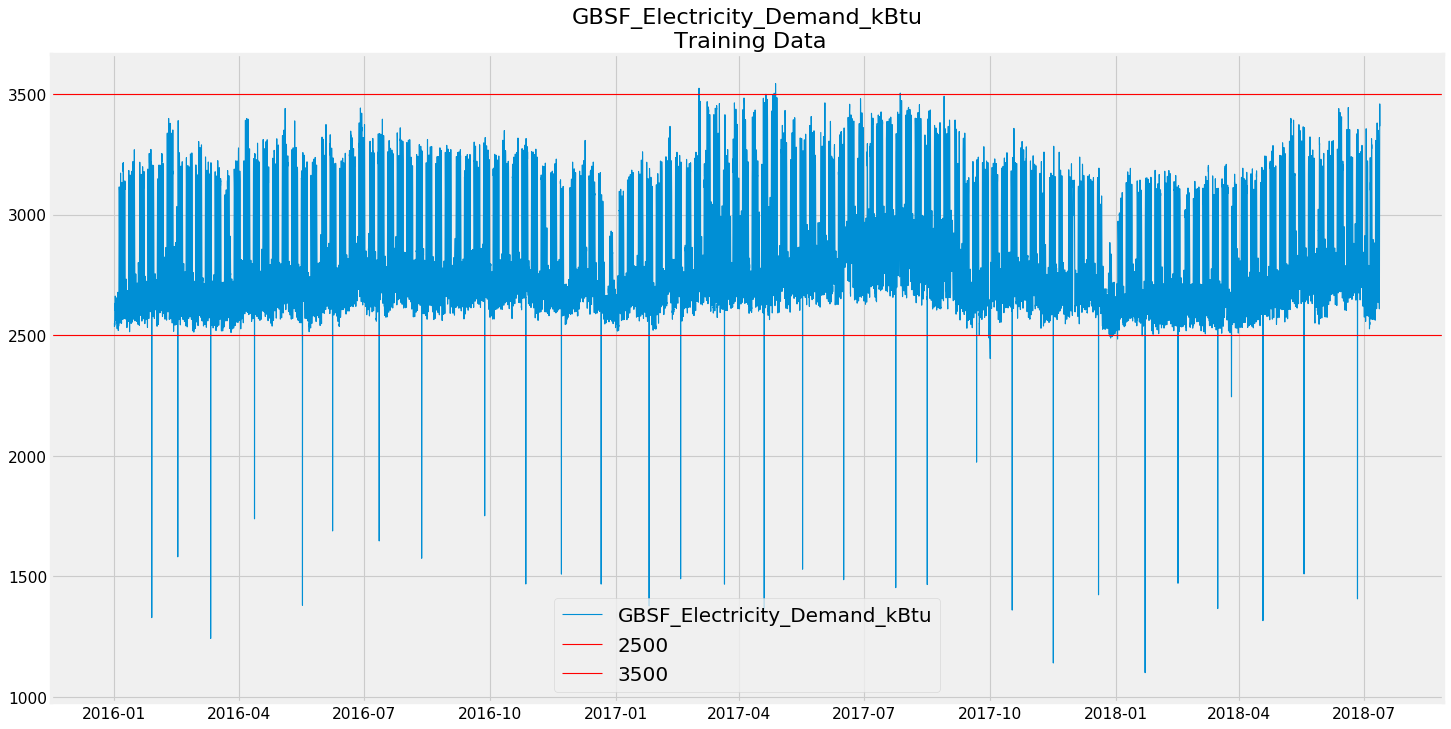

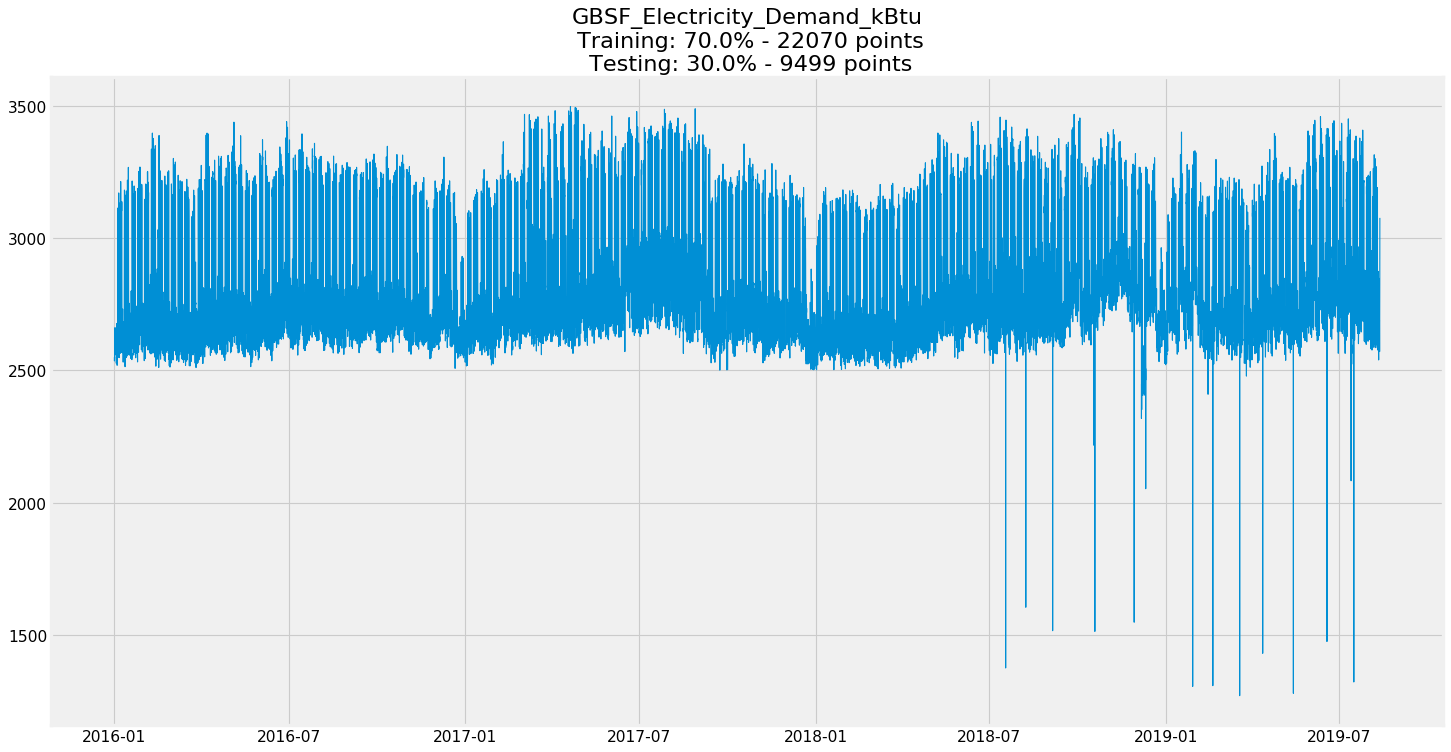

In [7]:
df1 = split_and_clean(df, kwargs)

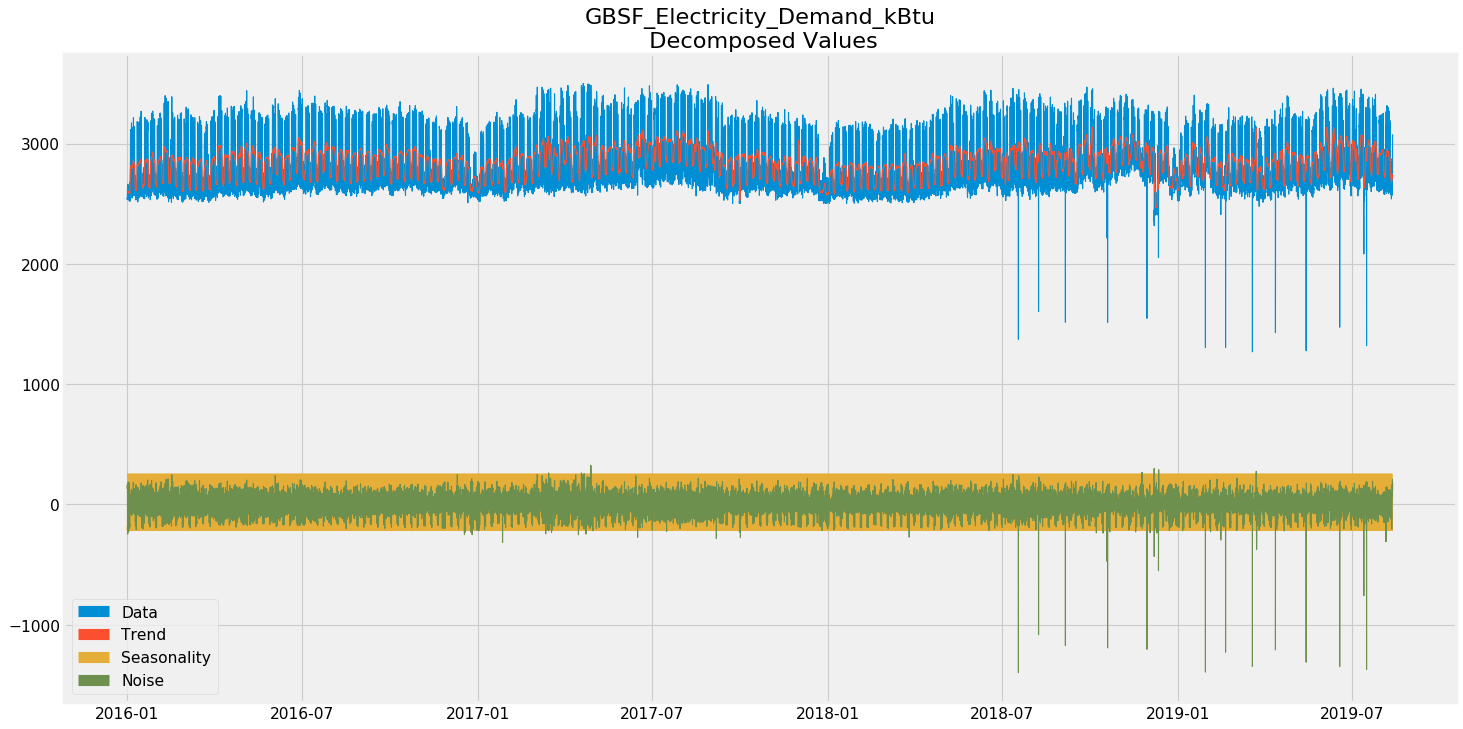

In [8]:
plot_decomposed_data(df1[point[0]], kwargs)

Using TensorFlow backend.


Grabbing WebIDs ...
WebID collection complete!
11:10:32: Sending API request... Chunk 1 of 1
11:10:36: Response recieved for 3 tags! (4.55)


W0812 11:10:37.613260 4477384128 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 11:10:37.632998 4477384128 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 11:10:37.637262 4477384128 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Removed: 0 rows


W0812 11:10:37.940226 4477384128 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0812 11:10:38.116825 4477384128 deprecation.py:323] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0812 11:10:38.895449 4477384128 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0812 11:10:38.989256 4477384128 deprecation_wrapper.py:119] From /Users/jos

Train on 15516 samples, validate on 6650 samples
Epoch 1/4
15516/15516 [==============================] - 3s 207us/step - loss: 0.0281 - val_loss: 0.0016
Epoch 2/4
15516/15516 [==============================] - 2s 132us/step - loss: 9.0659e-04 - val_loss: 0.0021
Epoch 3/4
15516/15516 [==============================] - 2s 129us/step - loss: 6.9367e-04 - val_loss: 0.0016
Epoch 4/4
15516/15516 [==============================] - 2s 129us/step - loss: 6.2377e-04 - val_loss: 8.0730e-04


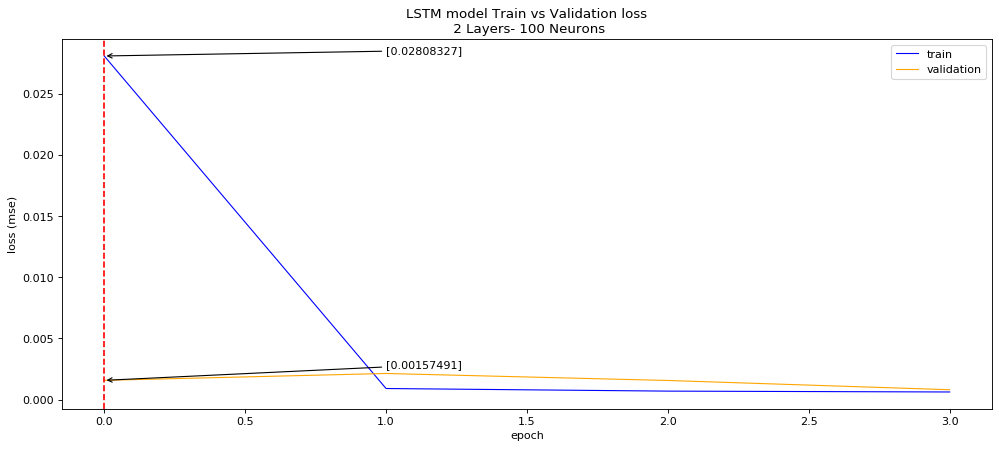

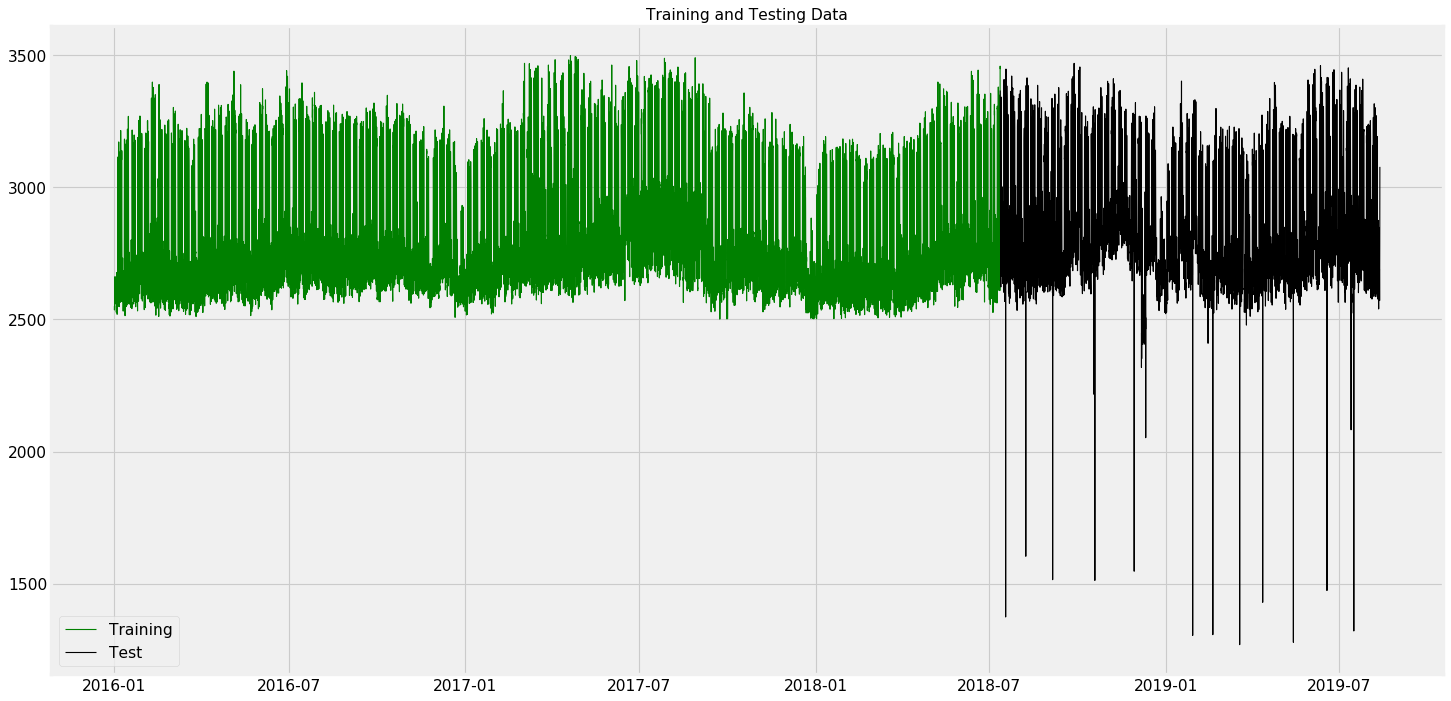

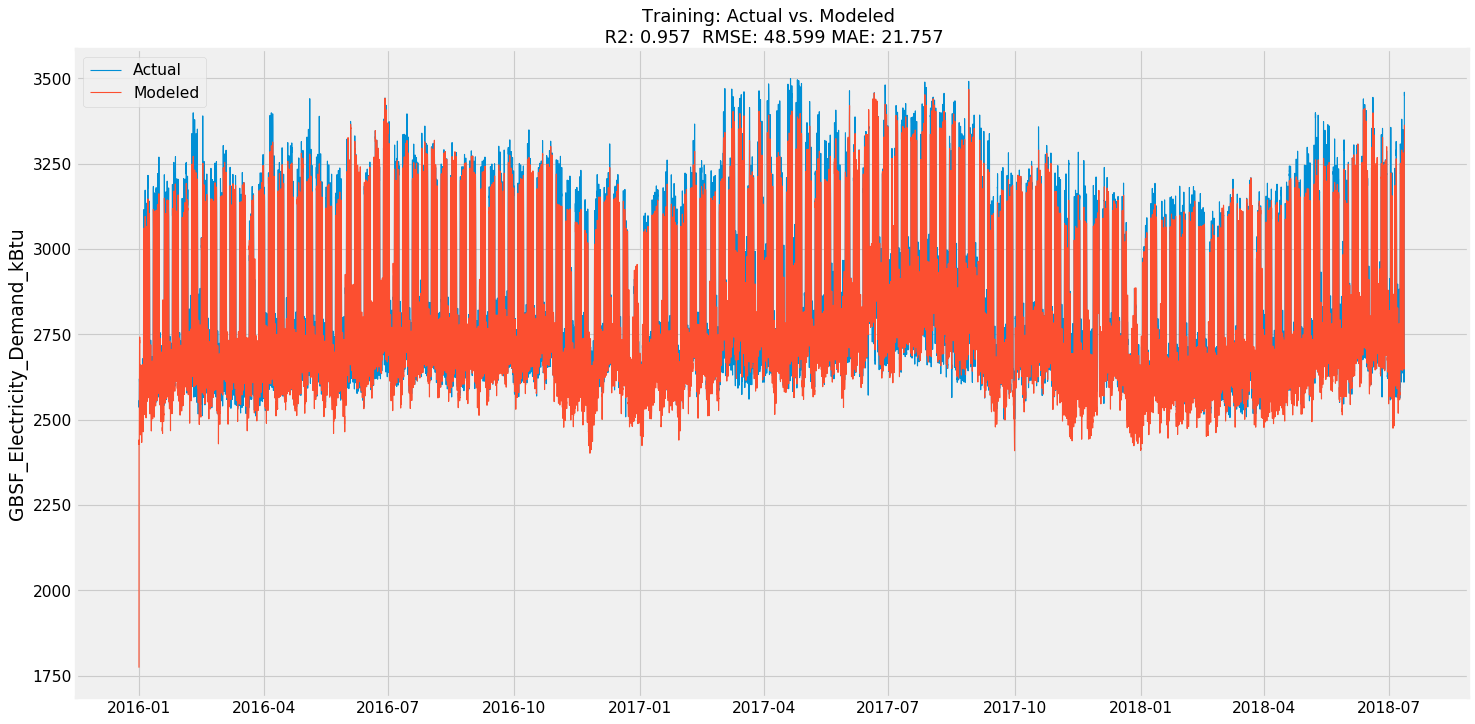

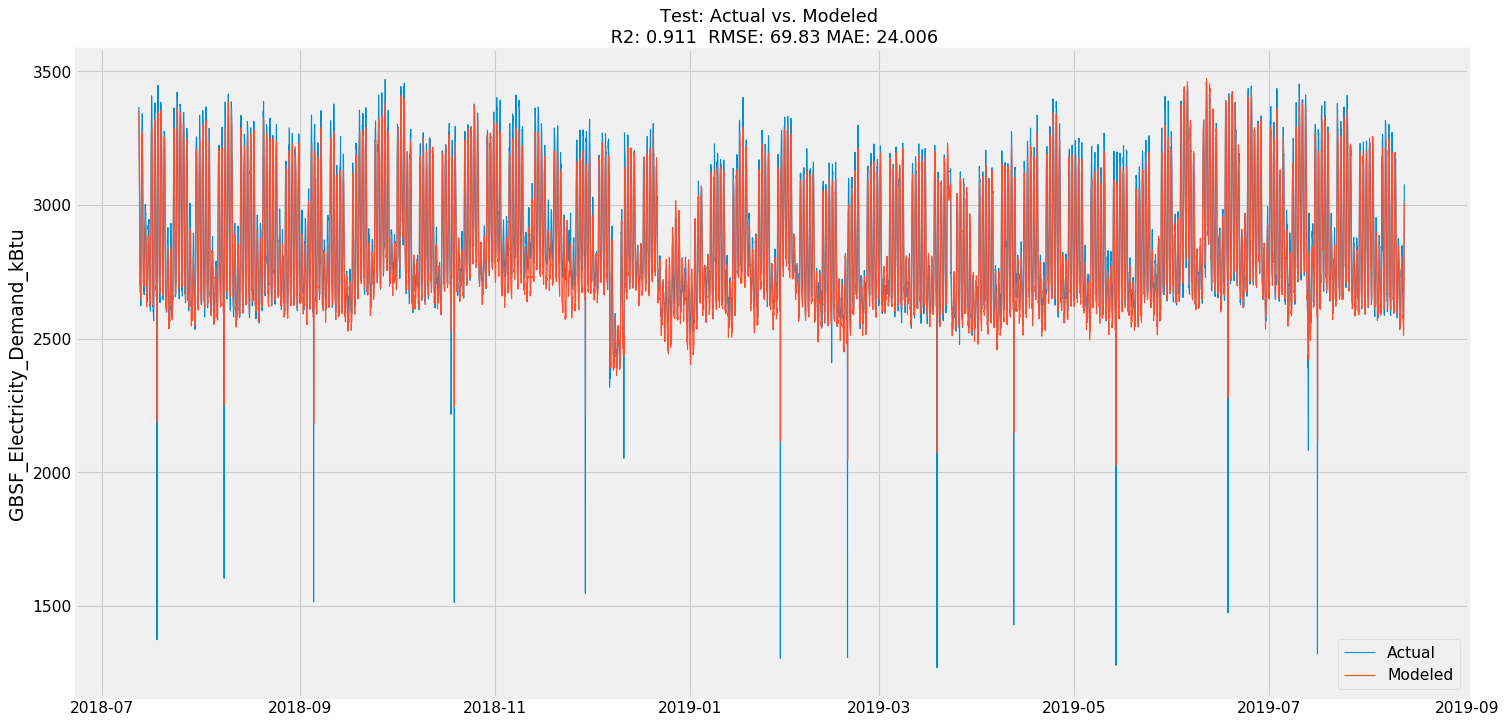

In [9]:
from model_generator import *
#model,X_train, X_test, y_train, y_test, scaler , train_idx, test_idx, data = create_model(df1, kwargs)
train_df, test_df = create_model(df1, kwargs)

In [ ]:
test_df.eval('Result = Modeled - Actual')[['Result']].hist(bins = 100, figsize = (20,10))

In [ ]:
test_df.eval('Result2 = (Modeled - Actual)**2')[['Result2']].plot(figsize = (20,10))

In [ ]:
test_df.eval('Result2 = (Modeled - Actual)**2')[['Result2']].hist(bins = 100,figsize = (20,10))

In [ ]:
test_df.eval('Result = Modeled - Actual', inplace = True)
test_df.to_csv('for_emma.csv')

In [ ]:
test_df